In [2]:
from google.cloud import bigquery
from openai import AzureOpenAI
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

os.environ["TOKENIZERS_PARALLELISM"] = "false"

client = bigquery.Client()

project_id_reviews = 'ingka-tugc-infra-prod'
dataset_id_reviews = 'eu_ai_content'
table_id_reviews = 'reviews'

table_ref_reviews = f'{project_id_reviews}.{dataset_id_reviews}.{table_id_reviews}'

project_id_prod_info = 'ingka-explainableai-tpu-dev'
dataset_id_prod_info = 'text_to_sql'
table_id_prod_info = 'item_dim'

table_ref_prod_info = f'{project_id_prod_info}.{dataset_id_prod_info}.{table_id_prod_info}'

# Query to get all the data - 1.17GB to process

query_all = f"""
    SELECT r.art_id, r.title, r.text, concat(r.title, '. ', r.text) as review_text, r.franchise, r.content_lang_code, r.updated_on, p.pa_name as product_area, type.name as type_name, p.item_name
    FROM {table_ref_prod_info} p 
    INNER JOIN {table_ref_reviews} r
    ON p.item_no = r.art_id
    WHERE p.item_no is not null AND franchise='set-11' AND content_lang_code = 'en'
"""

query_job = client.query(query_all)
df = query_job.to_dataframe()

print(df.head(5))

     art_id                      title  \
0  10486044  Like it cause it’s fabric   
1  30234229                Very good’s   
2  30583888         Rather reuse glass   
3  70551550          Great plant pot.    
4  30265659      Best part of my whole   

                                                text  \
0              It should come with a connecting wite   
1                                        Very good’s   
2  The bottle is good. Like that’s it is glass so...   
3   I wish I had bought the larger size. Next visit!   
4  Best part of my whole new kitchen. Friends are...   

                                         review_text franchise  \
0  Like it cause it’s fabric. It should come with...    set-11   
1                           Very good’s. Very good’s    set-11   
2  Rather reuse glass. The bottle is good. Like t...    set-11   
3  Great plant pot. . I wish I had bought the lar...    set-11   
4  Best part of my whole. Best part of my whole n...    set-11   

  content_lan

In [3]:
df["updated_on"] = pd.to_datetime(df["updated_on"])
df["review_text"] = df["review_text"].apply(lambda x: str(x).replace('$', ''))

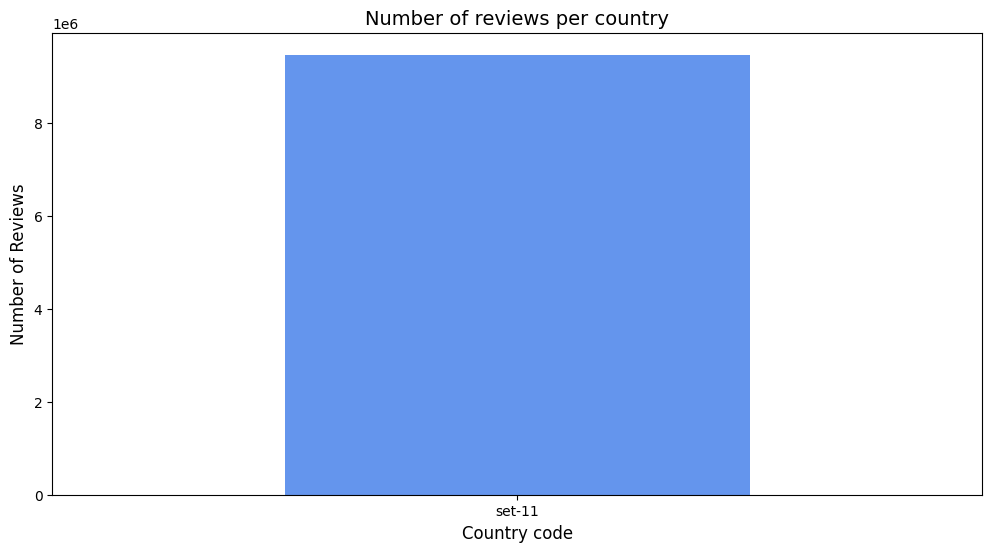

In [4]:
# 1 : Distribution and count

pivot_table = df.pivot_table(index='franchise', aggfunc='size', fill_value=0)

pivot_table.plot(kind='bar', figsize=(12, 6), color='cornflowerblue')

plt.title("Number of reviews per country", fontsize=14)
plt.xlabel("Country code", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=0)
plt.show()


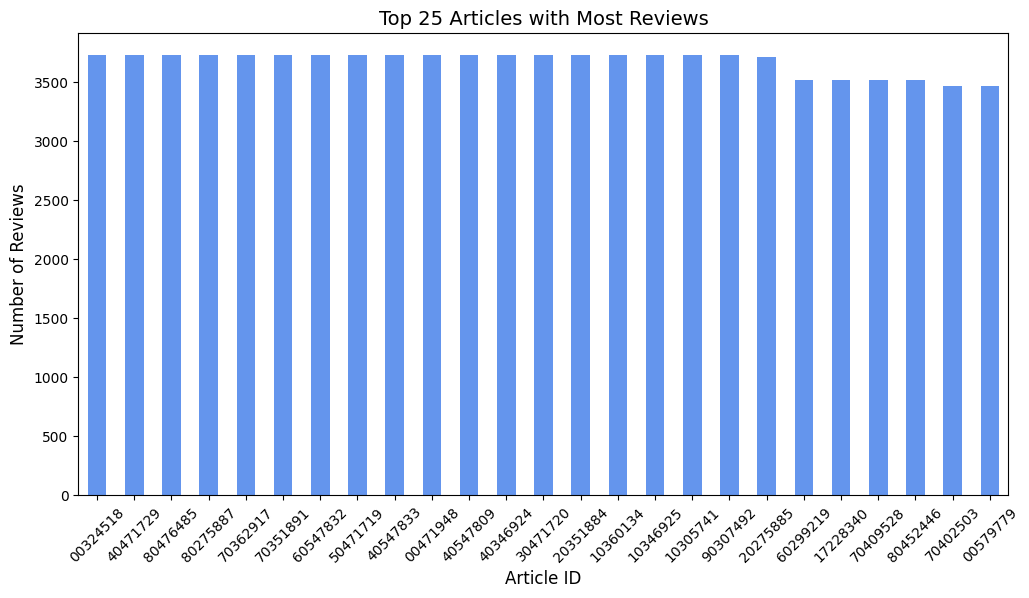


2. Articles Analysis:
Unique Articles: 104969
Top 25 Article Counts:
art_id
20351884    3729
90307492    3729
40547833    3729
40547809    3729
80476485    3729
10346925    3729
00324518    3729
00471948    3729
40471729    3729
30471720    3729
70362917    3729
10360134    3729
50471719    3729
70351891    3729
60547832    3729
80275887    3729
40346924    3729
10305741    3729
20275885    3713
70409528    3516
17228340    3516
60299219    3516
80452446    3516
70402503    3463
00579779    3463
Name: count, dtype: int64


In [5]:
# 2 art_id: Identify unique articles and counts
article_counts = df['art_id'].value_counts()
unique_articles = df['art_id'].nunique()

top_25_articles = article_counts.nlargest(25).index

df_top_25 = df[df['art_id'].isin(top_25_articles)]

pivot_table = df_top_25.pivot_table(index='art_id', aggfunc='size', fill_value=0)
pivot_table = pivot_table.sort_values(ascending=False)

pivot_table.plot(kind='bar', figsize=(12, 6), color='cornflowerblue')

plt.title("Top 25 Articles with Most Reviews", fontsize=14)
plt.xlabel("Article ID", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=45)
plt.show()

print("\n2. Articles Analysis:")
print(f"Unique Articles: {unique_articles}")
print("Top 25 Article Counts:")
print(article_counts.nlargest(25))


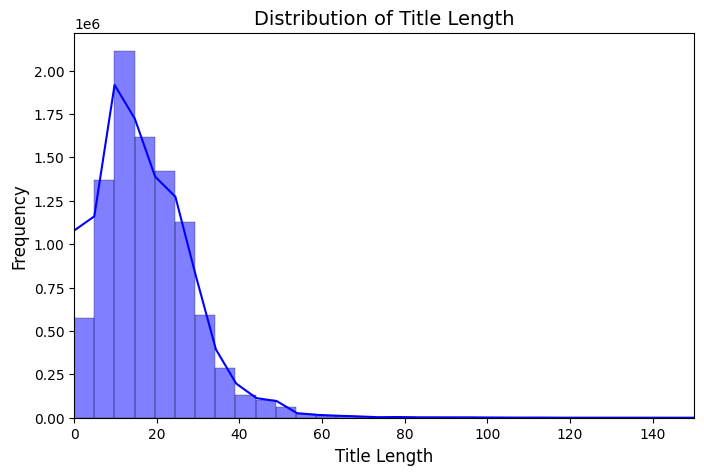


4. Title Length Analysis:
Statistical Summary:
count    9.460329e+06
mean     1.825087e+01
std      1.144491e+01
min      0.000000e+00
25%      1.100000e+01
50%      1.600000e+01
75%      2.500000e+01
max      9.760000e+02
Name: title_length, dtype: float64
Minimum Title Length: 0
Maximum Title Length: 976


In [6]:
# 4 title: Length analysis and distribution
df["title_length"] = df["title"].apply(len)
title_length_stats = df["title_length"].describe()

plt.figure(figsize=(8,5))
sns.histplot(df["title_length"], bins=200, kde=True, color="blue")
plt.xlim(0, 150)
plt.title("Distribution of Title Length", fontsize=14)
plt.xlabel("Title Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

print("\n4. Title Length Analysis:")
print("Statistical Summary:")
print(title_length_stats)
print("Minimum Title Length:", df["title_length"].min())
print("Maximum Title Length:", df["title_length"].max())

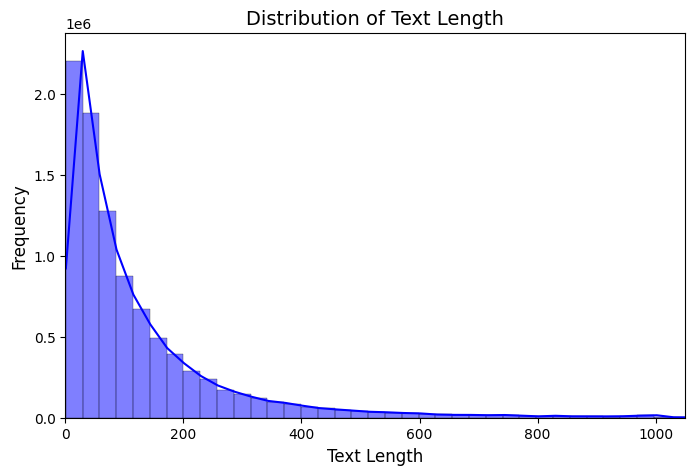


5. Text Length Analysis:
Statistical Summary:
count     9460329
unique     650993
top          Good
freq        79500
Name: text, dtype: object
Minimum Text Length: 1
Maximum Text Length: 5691


In [7]:
# 5 text: Length analysis (average, shortest, longest text length)
df["text_length"] = df["text"].apply(len)
text_length_stats = df["text"].describe()

plt.figure(figsize=(8,5))
sns.histplot(df["text_length"], bins=200, kde=True, color="blue", legend=False)
plt.xlim(0, 1050)
plt.title("Distribution of Text Length", fontsize=14)
plt.xlabel("Text Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

print("\n5. Text Length Analysis:")
print("Statistical Summary:")
print(text_length_stats)
print("Minimum Text Length:", df["text_length"].min())
print("Maximum Text Length:", df["text_length"].max())

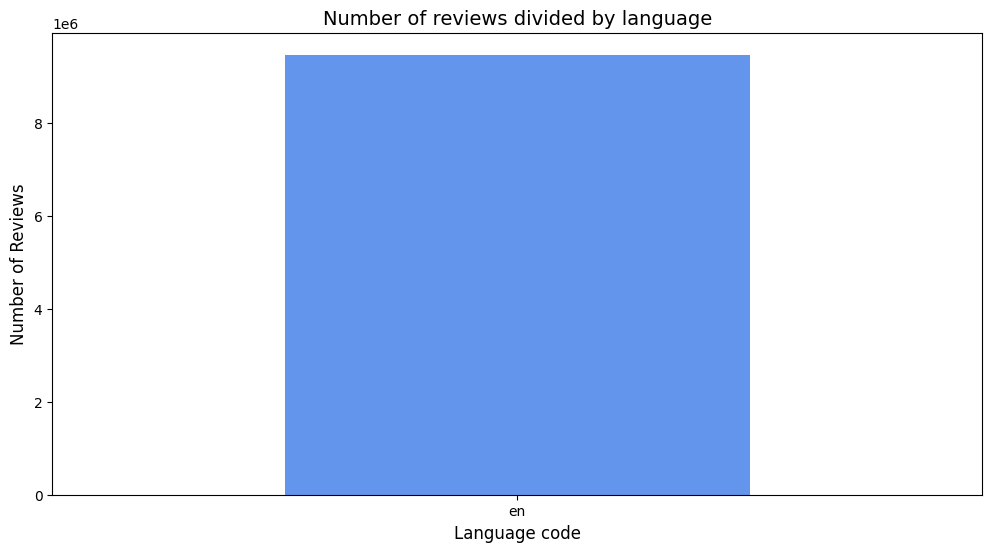

In [8]:
# 6 lang_code: Distribution and count

pivot_table = df.pivot_table(index='content_lang_code', aggfunc='size', fill_value=0)

pivot_table = pivot_table.sort_values(ascending=False)

pivot_table.plot(kind='bar', figsize=(12, 6), color='cornflowerblue')

plt.title("Number of reviews divided by language", fontsize=14)
plt.xlabel("Language code", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=0)
plt.show()


In [9]:
# 7 inserted_on: Most recent and oldest reviews
most_recent_review = df["updated_on"].max()
oldest_review = df["updated_on"].min()

print("\n7. Review Dates Analysis:")
print(f"Most Recent Review: {most_recent_review}")
print(f"Oldest Review: {oldest_review}")


7. Review Dates Analysis:
Most Recent Review: 2025-04-06 16:42:12+00:00
Oldest Review: 2023-05-02 07:15:39+00:00


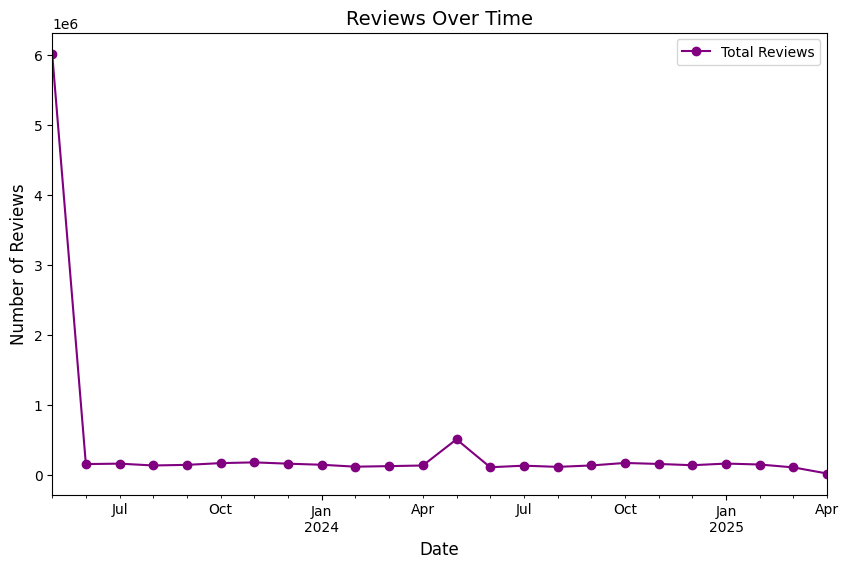

In [10]:
# 8 Reviews over time: number of reviews divided monthly

df_monthly = df.resample("ME", on="updated_on").size()

plt.figure(figsize=(10, 6))
df_monthly.plot(marker="o", linestyle="-", color="purple", label="Total Reviews")

plt.title("Reviews Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.legend()
plt.show()

Number of Product Areas: 208


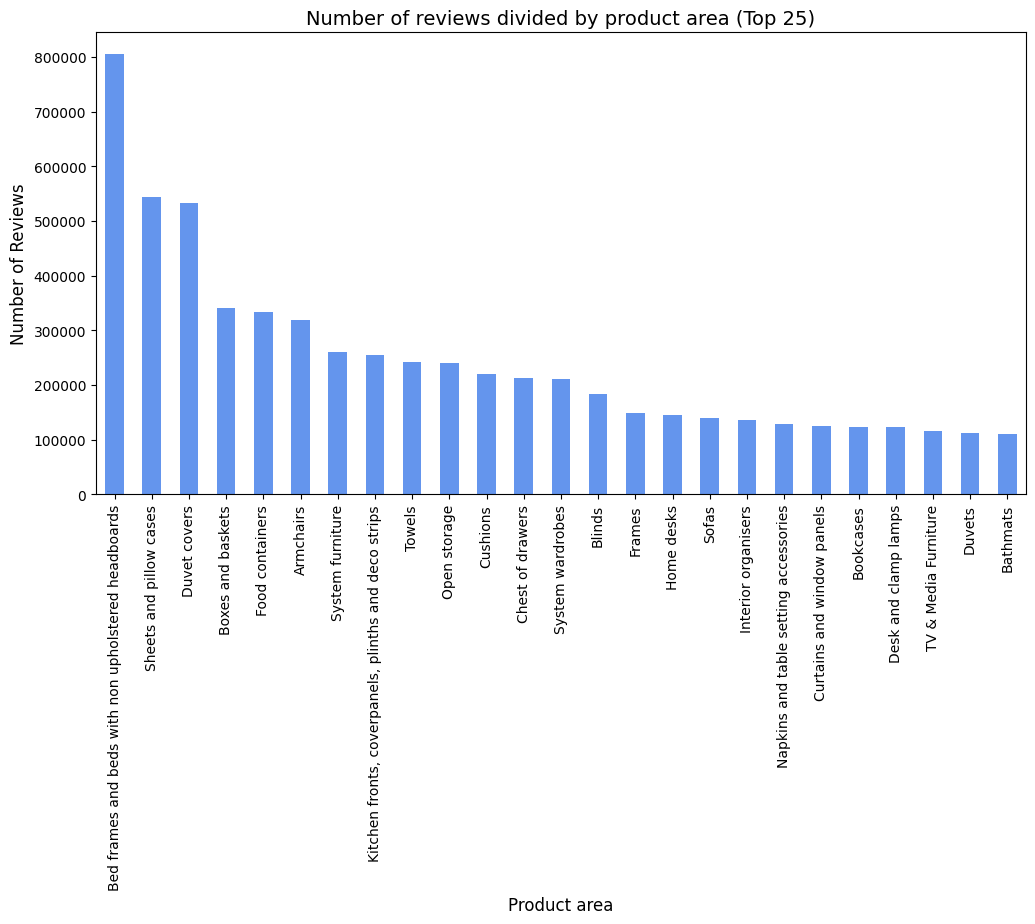

In [11]:
# 9 Product area: Distribution and count

area_counts = df['product_area'].value_counts()
print(f"Number of Product Areas: {df['product_area'].nunique()}")
top_25_areas = area_counts.nlargest(25).index

df_top_25 = df[df['product_area'].isin(top_25_areas)]

pivot_table = df_top_25.pivot_table(index='product_area', aggfunc='size', fill_value=0)

pivot_table = pivot_table.sort_values(ascending=False)

pivot_table.plot(kind='bar', figsize=(12, 6), color='cornflowerblue')

plt.title("Number of reviews divided by product area (Top 25)", fontsize=14)
plt.xlabel("Product area", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=90)
plt.show()

Number of Product Areas: 3287


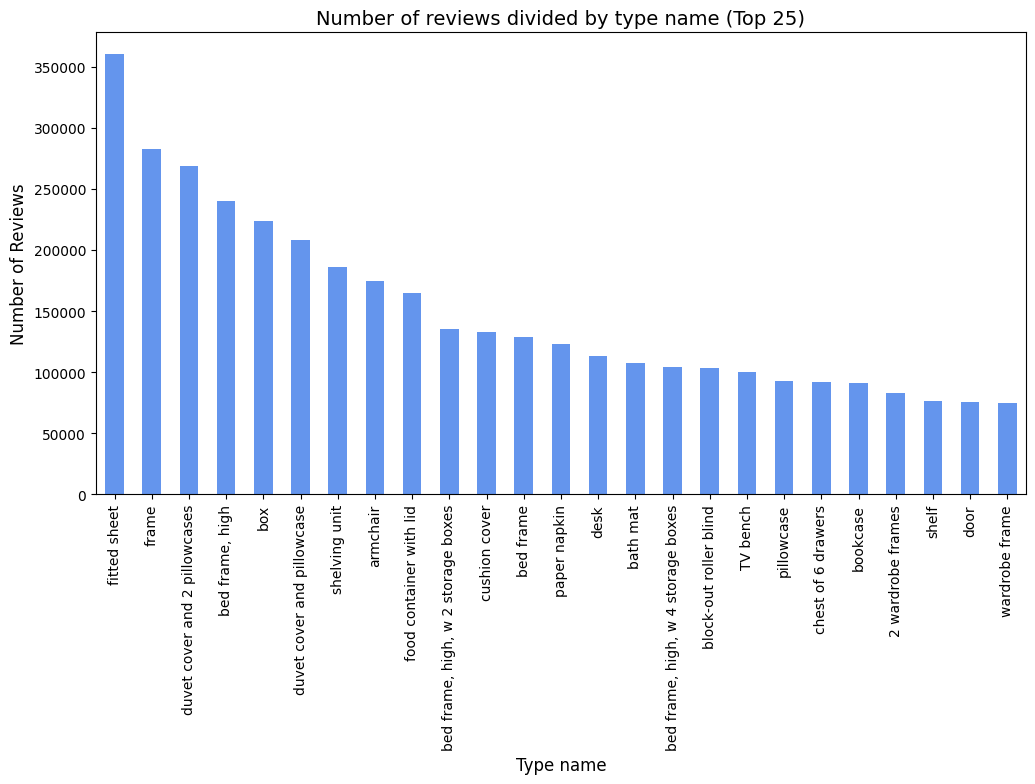

In [12]:
# 10 Type name: Distribution and count

type_counts = df['type_name'].value_counts()
print(f"Number of Product Areas: {df['type_name'].nunique()}")
top_25_types = type_counts.nlargest(25).index

df_top_25 = df[df['type_name'].isin(top_25_types)]

pivot_table = df_top_25.pivot_table(index='type_name', aggfunc='size', fill_value=0)

pivot_table = pivot_table.sort_values(ascending=False)

pivot_table.plot(kind='bar', figsize=(12, 6), color='cornflowerblue')

plt.title("Number of reviews divided by type name (Top 25)", fontsize=14)
plt.xlabel("Type name", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=90)
plt.show()

